<a href="https://colab.research.google.com/github/giganttheo/DPP/blob/master/DPP_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ce notebook est un supplément au dossier du projet Cassiopée de BUISSON Zacharie, GIGANT Théo et TROUCHE Eric

# Imports

`DPPy` est une bibliothèque qui implémente de nombreuses méthodes pour l'échantillonage de processus ponctuels déterminantaux en python.

Celle-ci nous permettra de vérifier que les algorithmes implémentés offrent des résultats similaires, et donc que nous n'avons pas commis d'erreurs.

[`DPPy`](https://github.com/guilgautier/DPPy/blob/master/docs/index.rst) a été développée par Guillaume Gautier et est accompagnée d'un [article](https://github.com/guilgautier/DPPy_paper).



In [ ]:
pip install dppy

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 6.4MB 12.6MB/s 
     |████████████████████████████████| 11.6MB 41.6MB/s 
     |████████████████████████████████| 286kB 37.4MB/s 
  Created wheel for oset: filename=oset-0.1.3-cp36-none-any.whl size=9661 sha256=0a76adff1cf5fbe2a6202446ffbd8c22b78f89d519657423c40f6fbefe6d0956
  Stored in directory: /root/.cache/pip/wheels/4e/87/c8/3dad2dca279f64fb68af5d9908c380fee2f16488a1b1da3499
Successfully built oset
ERROR: sphinxcontrib-bibtex 1.0.0 has requirement Sphinx>=2.0, but you'll have sphinx 1.8.5 which is incompatible.
  Found existing installation: cvxopt 1.2.5
    Uninstalling cvxopt-1.2.5:
      Successfully uninstalled cvxopt-1.2.5


In [ ]:
import numpy as np
import random
import scipy
from scipy.linalg import qr
from numpy.random import rand, randn
import sklearn.decomposition
import matplotlib.pyplot as plt


import dppy
from dppy.finite_dpps import FiniteDPP


#Méthode spectrale pour l'échantillonage de DPP


### Implémentation de l'algorithme de méthode spectrale

La fonction `spectral_method` implémente l'algorithme 1, en prenant pour paramètres `lambda_L` la liste des valeurs propres de $L$, `v_L` la liste des vecteurs propres de $L$ qui désigne la matrice .

On notera `N` la valeur de $N = Card(\mathcal{Y})$, et l'on prendra sans perte de généralité $\mathcal{Y} = [\![ 1, N ]\!]$.


In [ ]:
def spectral_method(lambda_L, v_L):
  N = lambda_L.shape[0]
  J = [] #J va accueillir les vecteurs propres qui formeront le DPP élémentaire selon lequel on échantillone dans la deuxième partie de l'algorithme
  for n in range(N):
      if random.random() < (lambda_L[n] / (1 + lambda_L[n])):
        #chaque vecteur propre à une probabilité `lambda_L[n] / (1 + lambda_L[n])` d'appartenir à J
        J.append(n)
  V = [v_L[n] for n in J]
  Y = []
  #Fin de la première partie l'algorithme : on va maintenant échantilloner selon le DPP élémentaire de vecteurs propres dans V
  while len(V) > 0:
      rd = random.random()
      s = 0
      i = 0
      while rd > s:
        #cette boucle permet de choisir $i$ dans $\mathcal(Y)$ avec une probabilité $\sigma_{v \in V}(np.dot(v.T,ei)**2) / len(V)$
        ei = [0 for _ in range(N) ]
        ei[i] = 1
        ei = np.array(ei)
        for v in V:
          s += (np.dot(v.T,ei)**2) / len(V) 
        i += 1
      Y.append(i)
      if len(V) > 1 :
          #On projette V sur l'orthogonal de ej puis on en déduit une base V_orth orthonormée, de rang Card(V) - 1
          V_orth = []
          for v in V :
              V_orth.append(v - np.dot(v.T,ei)*ei)
          #le nouveau V_J est une base orthogonale
          V = scipy.linalg.orth(np.array(V_orth[:-1]).T).T
          #on remplace V par cette nouvelle base orthonormée, le cardinal de V est donc réduit de 1 à chaque passage de boucle
      else :
        #dans le cas où le cardinal de V était 1, c'est le dernier passage de boucle
        V = []
  return Y

### Fonctions utiles

In [ ]:
def moyenne(liste):
  S = 0
  for i in liste :
      S += i
  return S/len(liste)


def variance(samples):
  list_distances = []
  for sample in samples :
      if sample == [] :
          list_distances.append(0)
      else :
          milieu = sample[0]*0
          for i in sample :
              milieu += B[i-1]
          milieu = milieu / len(sample)
          dist = 0
          for i in sample :
              dist += np.sum((B[i-1] - milieu)**2)
          list_distances.append(dist / len(sample))
  return list_distances

def normaliser_vecteurs(list_vect):
  R = []
  for i in range(list_vect.shape[0]) :
    if np.sum(np.abs(list_vect[i])) != 0 :
      R.append(list_vect[i]/np.sqrt(np.sum((list_vect[i])**2)))
    else :
      R.append(list_vect[i])
  return np.array(R)



def afficher_coord(coord, couleur = ".", titre = ""):
  plt.plot(coord[:,0], coord[:,1], couleur)
  plt.axis('equal')
  plt.xticks([])
  plt.yticks([])
  plt.title(titre)
  plt.show()

from mpl_toolkits.mplot3d import Axes3D

def afficher_3d(coord, couleur = ".", titre = ""):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot(coord[:,0], coord[:,1], coord[:,2],couleur)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
  ax.set_xbound(0,1)
  ax.set_ybound(0,1)
  ax.set_zbound(0,1)
  ax.set_title(titre)
  plt.show()

### Echantillonage à partir d'un noyau de vecteurs et valeurs propres aléatoires
On prend $L = \Sigma _{n = 1}^{N} \frac{\lambda_{K,n}}{1-\lambda_{K,n}} v_n v_n^T$ avec $\lambda_{K,n}$ les valeurs propres de $K$, telles donc, si $\forall n \in [\![ 1, N ]\!], \lambda_{K,n} \neq 1$ que $\forall n \in [\![ 1, N ]\!] \lambda_n = \frac{\lambda_{K,n}}{1-\lambda_{K,n}}$ (ce qui découle directement de l'équation $(1.5)$).

On va générer aléatoirement des vecteurs propres qui forment une famille $V$ orthogonale, et des valeurs propres $\{\lambda_{K,n}\}_{n\in [\![ 1, N ]\!]}$ dans $[0,1[$ pour construire $L$.

On aura alors directement la décomposition spectrale de $L$.

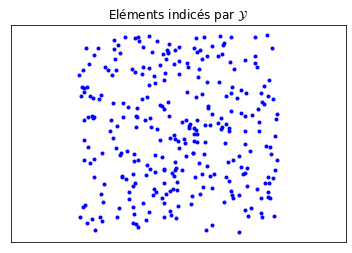

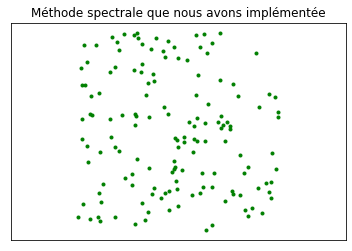

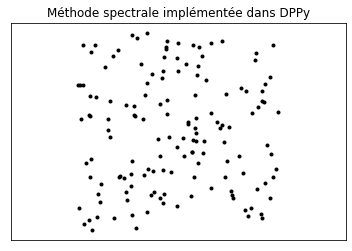

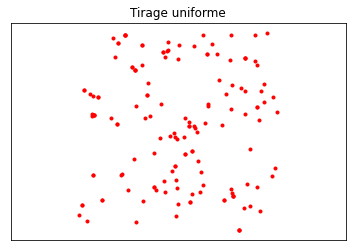

In [ ]:
N = 300
Y_rond = [i for i in range(1,N+1)] #l'ensemble parmi lequel les points sont tirés

espace = 2*(0.5 - np.random.rand(N,2))

eig_vecs, _ = qr(randn(N, N), mode='economic')
eig_vals = rand(N)
#on en déduit la décomposition spectrale de L
lambda_L = eig_vals/(1-eig_vals)
v_L = eig_vecs
L = (eig_vecs*(eig_vals/(1-eig_vals))).dot(eig_vecs.T)

L_samples = []
L_samples.append(spectral_method(lambda_L, v_L)) #un tirage de DPP de noyau de vraisemblance L

L_uniform = [[random.sample(Y_rond, 1)[0] for _ in range(len(L_samples[k]))] for k in range(len(L_samples))]
#tirage indépendant selon une probabilité uniforme du même nombre d'éléments que le DPP, avec remise
#cela nous permettra de visualiser l'intérêt d'un DPP

DPP = FiniteDPP('likelihood',
                **{'L_eig_dec': (lambda_L, v_L)})
DPP.sample_exact()
#on utilise la bibliothèque DPPy pour tirer des points avec la même méthode, et comparer les résultats avec l'algorithme que l'on a implémenté

afficher_coord(espace, "b." ,r"Eléments indicés par $\mathcal{Y}$")

coord_samples = np.array([espace[i-1] for i in L_samples[-1]])
coord_dppy = np.array([espace[i-1] for i in DPP.list_of_samples[-1]])
coord_uniform = np.array([espace[i-1] for i in L_uniform[-1]])
afficher_coord(coord_samples, "g.", r"Méthode spectrale que nous avons implémentée")
afficher_coord(coord_dppy, "k.", r"Méthode spectrale implémentée dans DPPy")
afficher_coord(coord_uniform, "r.", r"Tirage uniforme")

Malheureusement avec cette méthode il n'existe pas de lien entre la position des points et la répulsion créée par les DPP.

Nous allons donc introduire une représentation qui permet de générer des DPP avec une répulsion corrêlée avec la position des points.

### Echantillonage à partir d'une matrice de Gram
On prend $B \in ({ {\rm I\!R} ^{dim}})^{N}$ qui contient des vecteurs tels que si $x,y \in B$, $<x;y> = x^Ty$

Le code qui va suivre permet d'échantilloner selon un DPP de noyau de vraisemblance $L$, avec $L = B^TB$

$L$ est une matrice de Gram.

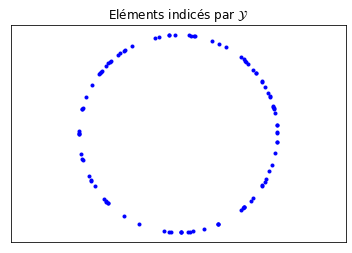

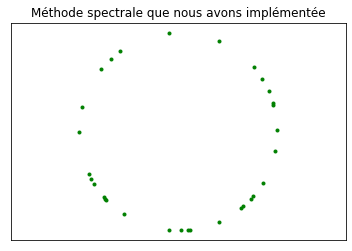

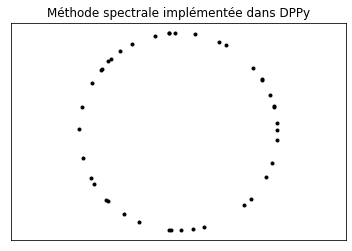

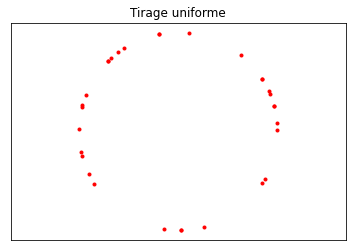

In [ ]:
N = 100
dim = 2
Y_rond = [i for i in range(1,N+1)] #l'ensemble parmi lequel les points sont tirés


B = normaliser_vecteurs(2*(0.5 - np.random.rand(N,dim))) #représente les vecteurs positions de N points du cercle trigonométrique
#les vecteurs sont normalisés, cela correspond donc à la représentation de la diversité dans l'interprétation géométrique qualité vs diversité des DPP
q = np.array([[1]*dim]*N) #Les qualités correspondantes, ici on laisse 1 par défaut
L = np.dot(q * B,B.T * q.T) #cf interpretation géométrique de L : qualité vs diversité
for i in range(N):
  L[i,i] = L[i,i] * 1.5

w, v = np.linalg.eigh(L) #décomposition spectrale de L
lambda_L = w
v_L = v

L_samples = []
L_samples.append(spectral_method(lambda_L, v_L)) #un tirage de DPP de noyau de vraisemblance L

L_uniform = [[random.sample(Y_rond, 1)[0] for _ in range(len(L_samples[k]))] for k in range(len(L_samples))]
#tirage indépendant selon une probabilité uniforme du même nombre d'éléments que le DPP, avec remise
#cela nous permettra de visualiser l'intérêt d'un DPP

DPP = FiniteDPP('likelihood',
                **{'L_eig_dec': (lambda_L, v_L)})
DPP.sample_exact()
#on utilise la bibliothèque DPPy pour tirer des points avec la même méthode, et comparer les résultats avec l'algorithme que l'on a implémenté

afficher_coord(B, "b." ,r"Eléments indicés par $\mathcal{Y}$")

coord_samples = np.array([B[i-1] for i in L_samples[-1]])
coord_dppy = np.array([B[i-1] for i in DPP.list_of_samples[-1]])
coord_uniform = np.array([B[i-1] for i in L_uniform[-1]])
afficher_coord(coord_samples, "g.", r"Méthode spectrale que nous avons implémentée")
afficher_coord(coord_dppy, "k.", r"Méthode spectrale implémentée dans DPPy")
afficher_coord(coord_uniform, "r.", r"Tirage uniforme")

En prenant une représentation vectorielle de points dans un espace à 2 dimensions, on peut utiliser la représentation "qualité/diversité" qui permet de créer une répulsion entre les points proches et de favoriser les ensembles de points dont la famille de vecteurs forment un volume de grande valeur.

On écrit $\forall i \in [ \! [ 1, N ] \!], B_i = q_i\phi_i^T$

Le vecteur "diversité" $\phi_i$ est unitaire et tel que si $i$ et $j$ sont similaires, l'angle $\widehat{(\phi_i, \phi_j)}$ sera petit.

$q_i$ est positif et représente la qualité du point $i$ : plus cette valeur sera élevée, plus ce point aura de chance d'être tiré.

On voit dans les tirages de la cellule précédente qu'une répulsion apparait bien pour les tirages à partir de DPP.

Dans la cellule suivante, on effectue le même tirage mais cette fois-ci pour des points sur la sphère trigonométrique.

On peut généraliser cette méthode à toute représentation de points dans un espace de dimension quelconque, tel que deux points proches sémantiquement auront des vecteurs de directions proches, et dont la pertinence sera correlée avec la norme du vecteur.

Une telle représentation peut être apprise par une méthode d'apprentissage automatique par exemple.

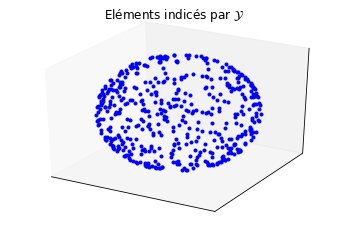

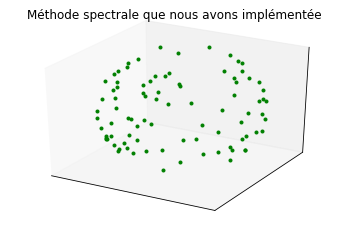

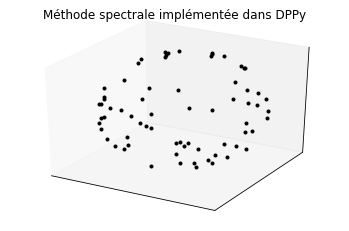

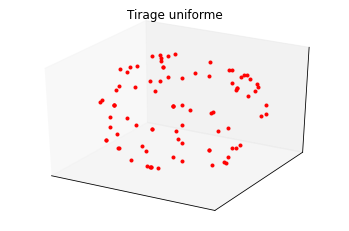

In [ ]:
N = 500
dim = 3
Y_rond = [i for i in range(1,N+1)] #l'ensemble parmi lequel les points sont tirés


B = normaliser_vecteurs(2*(0.5 - np.random.rand(N,dim))) #représente les vecteurs positions de N points de la sphère trigonométrique
#les vecteurs sont normalisés, cela correspond donc à la représentation de la diversité dans l'interprétation géométrique qualité vs diversité des DPP
q = np.array([[1]*dim]*N) #Les qualités correspondantes, ici on laisse 1 par défaut
L = np.dot(q * B,B.T * q.T) #cf interpretation géométrique de L : qualité vs diversité

for i in range(N):
  L[i,i] = L[i,i] * 1.2


w, v = np.linalg.eigh(L) #décomposition spectrale de L
lambda_L = w
v_L = v

L_samples = []
L_samples.append(spectral_method(lambda_L, v_L)) #un tirage de DPP de noyau de vraisemblance L

L_uniform = [[random.sample(Y_rond, 1)[0] for _ in range(len(L_samples[k]))] for k in range(len(L_samples))]
#tirage indépendant selon une probabilité uniforme du même nombre d'éléments que le DPP, avec remise
#cela nous permettra de visualiser l'intérêt d'un DPP

DPP = FiniteDPP('likelihood',
                **{'L_eig_dec': (lambda_L, v_L)})
DPP.sample_exact()
#on utilise la bibliothèque DPPy pour tirer des points avec la même méthode, et comparer les résultats avec l'algorithme que l'on a implémenté

espace = B
afficher_3d(espace, "b." ,r"Eléments indicés par $\mathcal{Y}$")

coord_samples = np.array([espace[i-1] for i in L_samples[-1]])
coord_dppy = np.array([espace[i-1] for i in DPP.list_of_samples[-1]])
coord_uniform = np.array([espace[i-1] for i in L_uniform[-1]])
afficher_3d(coord_samples, "g.", r"Méthode spectrale que nous avons implémentée")
afficher_3d(coord_dppy, "k.", r"Méthode spectrale implémentée dans DPPy")
afficher_3d(coord_uniform, "r.", r"Tirage uniforme")

# Apprentissage et DPP



Une méthode proposée par [Kulesza et Taskar](https://arxiv.org/abs/1202.3738) pour un système de résumé extractif de textes utilise les DPP, et on peut s'en inspirer pour d'autres applications en apprentissage automatique (système de recommandation par exemple).

Le principe est d'apprendre les coefficients de la matrice de vraisemblance $L$ du DPP en s'entraînant sur des exemples de tirages aléatoires que l'on souhaite imiter.

La base de données $(X,Y)$ désigne alors l'ensemble des points et des tirages parmi celui-ci. Le but sera de modifier les paramètres de $L$ afin que ${\rm I\!P}(Y|X)$ soit maximale.

On pose alors $\theta \in {\rm I\!R}^d$ un vecteur qui paramètrera $L$.

On pose $\forall i \in [\![ 1, N ]\!], f_i(X) \in {\rm I\!R}^d$ un vecteur de caractéristique du point $i$, $q_i(X) = {\rm exp}(\frac{1}{2}\theta^Tf_i(X))$ qui correspond à la qualité de $i$ et $\phi_i(X)$ qui permettra de mesurer la similarité de $i$ avec les autres éléments de $\mathcal{Y}(X)$.

On utilise alors la représentation qualité vs diversité, et on défini alors $L$ de la manière suivante :
$$\forall i,j \in [\![ 1, N ]\!]^2, L_{i,j}(X) = q_i(X) \phi_i(X)^T \phi_j(X) q_j(X)$$

On associe au modèle une fonction de score, la log-vraisemblance
$\mathcal{L}(\theta) = log({\rm I\!P}_\theta(Y|X)) = \Sigma_t log({\rm I\!P}_\theta(Y^t|X^t)$ qu'il conviendra de maximiser.

Pour cela, on peut montrer que cette fonction sera concave en $\theta$, donc on peut utiliser la méthode de montée de gradient pour trouver le maximum global de cette fonction de score.

On implémente l'algorithme $2$ pour calculer $\nabla\mathcal{L}(\theta)$ :

In [ ]:
def calc_L(theta, f_X, phi):
  #cette fonction permet de calculer L
  N = len(f_X)
  L = np.zeros((N,N))
  q = []
  for i in range(N):
    q.append(np.exp(0.5 * np.dot(theta.T, f_X[i])))
  for i in range(N):
    for j in range(N):
      L[i,j] = q[i] * np.dot(phi[i].T, phi[j]) * q[j]
  return L


def gradient_logvraisemblance(Y_t, theta, f_X, phi):
  #implémentation de l'algorithme permettant de calculer le gradient de la log-vraisemblance
  N = len(f_X)
  L = calc_L(theta, f_X, phi)
  lambda_L, v_L = np.linalg.eigh(L)
  K = np.zeros(N)
  for i in range(N):
    for n in range(N):
      K[i] += lambda_L[n]/(lambda_L[n] + 1) * v_L[n][i] ** 2
  grad = 0
  for i in range(N):
    grad += - K[i]*f_X[i]
  for i in Y_t:
    grad += f_X[i]
  return grad


def logvraisemblance(Y, theta, f_X, phi):
  #calcul de la log-vraisemblance (pour afficher la courbe d'apprentissage)
  N = len(f_X)
  SY = np.dot(phi.T, phi)
  def SY_t(t):
    return np.dot(np.array([phi[i] for i in Y[t]]).T, np.array([phi[i] for i in Y[t]]))
  s = 0
  for i in range(N):
    s += f_X[i]
  lin = np.dot(theta ,s)
  cst = np.log(np.linalg.det(SY))
  conc = - np.log(np.sum([np.exp(np.dot(theta, np.sum([f_X[i] for i in Y[t]]))) * np.linalg.det(SY_t(t)) for t in range(len(Y))]))
  R = lin + cst + conc
  return R

On peut alors implémenter une méthode de montée de gradient pour maximiser la log-vraisemblance du DPP sur une base d'entraînement.

Pour simplifier, la base d'entraînement sera générée par un autre type de DPP (avec la méthode des $\beta$-ensembles, issue de `DPPy`) en fonction de $\theta$. De plus on prendra $\phi_i = f_i = (i \in \mathcal{Y} \mapsto (x_i,y_i))$.

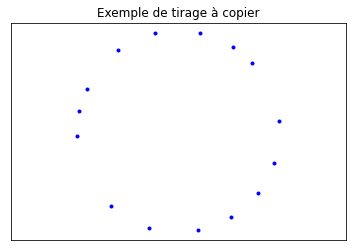

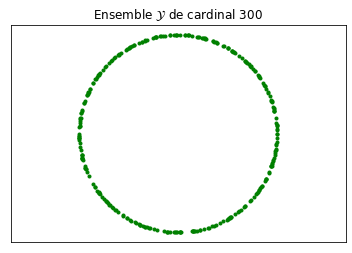

In [ ]:
from dppy.beta_ensembles import CircularEnsemble

db = [] #base de donnée d'entrainement
Y_rond = [] #ensemble des indices des points
size_N = 15 #nombre de points tirés par le DPP à partir de beta-ensembles
espace = [] #ensemble des positions des points indicés par Y_rond


for _ in range(20): #on tire 20 fois à partir d'un tel DPP
  circular = CircularEnsemble(beta=3)
  circular.sample_banded_model(size_N=size_N)
  db.append([[z.real, z.imag] for z in circular.list_of_samples[0]])
  circular.flush_samples()


db = np.array(db)
Y = [] #liste des listes d'indices des éléments tirés dans les exemples

for i in range(len(db)):
  Y.append([])
  for j in range(len(db[i])):
    Y_rond.append(size_N*i + j)
    espace.append(db[i][j])
    Y[-1].append(size_N*i + j)


afficher_coord(db[0],"b.","Exemple de tirage à copier")
afficher_coord(np.array(espace), "g.", r"Ensemble $\mathcal{Y}$ de cardinal "+f"{len(Y_rond)}")

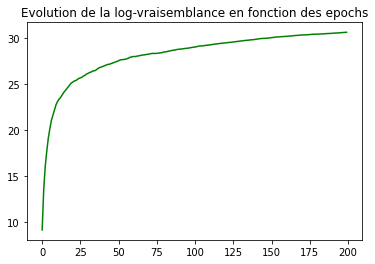

In [ ]:
d = 2 #dimension de l'espace des caractéristiques
N = len(Y_rond) #cardinal de Y_rond
theta = np.random.rand(d) #paramètres initiaux aléatoires
f_X = np.array(espace)
phi = f_X

epochs = 200
epsilon = 0.5

H = [] #historique des valeurs de la log-vraisemblance
inertia = np.zeros(2)

for epoch in range(1, epochs + 1):
  for t in range(len(Y)) :
    inertia = 0.8*inertia + 0.2*gradient_logvraisemblance(Y[t], theta, f_X, phi)
    theta += ( epsilon / epoch ) * inertia #descente de gradient avec inertie et learning rate decay
  H.append(logvraisemblance(Y, theta, f_X, phi))

plt.plot([i for i in range(len(H))],H,"g-")
plt.title("Evolution de la log-vraisemblance en fonction des epochs")
plt.show()

On voit d'après cette courbe qu'il y a bien apprentissage : la log-vraisemblance augmente effectivement au cours des epochs, et on a prouvé plus tôt que cette mesure était concave, donc lorsque l'on atteindra un maximum ça sera son maximum global. La méthode de montée de gradient converge donc vers la solution optimale pour ce modèle.

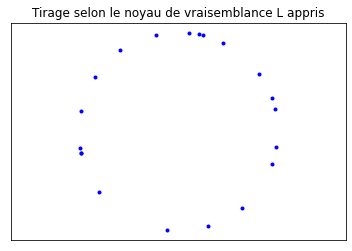

In [ ]:
L = calc_L(theta, f_X, phi)
for i in range(len(L)):
  L[i,i] = 1.0002*L[i,i]
w, v = np.linalg.eigh(L) #décomposition spectrale de L
lambda_L = w
v_L = v
L_samples = []
L_samples.append(spectral_method(lambda_L, v_L)) #un tirage de DPP de noyau de vraisemblance L

coord_samples = np.array([espace[i-1] for i in L_samples[-1]])
afficher_coord(coord_samples, "b.", "Tirage selon le noyau de vraisemblance L appris")